Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Training an Instance Segmentation model using AutoML
In this notebook, we go over how you can use AutoML for training an Instance Segmentation model. We will use a small dataset to train the model, demonstrate how you can tune hyperparameters of the model to optimize model performance and deploy the model to use in inference scenarios.

## Setup
To use this notebook, you will need to install the private preview package for AutoML for images from the private index.

### Note: Only Python 3.6 and 3.7 are supported for this feature.

In [2]:
%env AZURE_EXTENSION_DIR=/home/schrodinger/automl/sdk-cli-v2/src/cli/src
%env AZURE_ML_CLI_PRIVATE_FEATURES_ENABLED=true

env: AZURE_EXTENSION_DIR=/home/schrodinger/automl/sdk-cli-v2/src/cli/src
env: AZURE_ML_CLI_PRIVATE_FEATURES_ENABLED=true


In [3]:
# %pip install --upgrade "azureml-train-core<0.1.1" "azureml-train-automl<0.1.1" "azureml-contrib-dataset<0.1.1" --extra-index-url "https://azuremlsdktestpypi.azureedge.net/automl_for_images_private_preview/"

### Note: You might need to restart the notebook kernel after installing the packages from within the notebook with the line above, for the packages to be available to use.

### Licensing Information - 
This preview software is made available to you on the condition that you agree to
[your agreement][1] governing your use of Azure, and to the Supplemental Terms of Use for Microsoft Azure Previews[2], which supplement your agreement governing your use of Azure.
If you do not have an existing agreement governing your use of Azure, you agree that 
your agreement governing use of Azure is the [Microsoft Online Subscription Agreement][3]
(which incorporates the [Online Services Terms][4]).
By using the software you agree to these terms. This software may collect data
that is transmitted to Microsoft. Please see the [Microsoft Privacy Statement][5]
to learn more about how Microsoft processes personal data.

[1]: https://azure.microsoft.com/en-us/support/legal/
[2]: https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/
[3]: https://azure.microsoft.com/en-us/support/legal/subscription-agreement/
[4]: http://www.microsoftvolumelicensing.com/DocumentSearch.aspx?Mode=3&DocumentTypeId=46
[5]: http://go.microsoft.com/fwlink/?LinkId=248681 


## Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription, or load an existing workspace.

## Initialize ML Client
Create an MLClient object to interact with AzureML resources such as computes and jobs

In [4]:
import azure.ml
from azure.ml import MLClient
from azure.ml.entities import Workspace


subscription_id = 'e9b2ec51-5c94-4fa8-809a-dc1e695e4896'
resource_group_name = 'sajin_master'
workspace_name = "sajin_enterprise"

# TODO: will we support workspace creation through the nb?
client = MLClient(subscription_id, resource_group_name, default_workspace_name=workspace_name)

client

## Intialize MLFlow Client
Create an MLFlowClient to interact with the resources that the AutoML job creates, such as models, metrics.


In [5]:
!pip install azureml-core azureml-mlflow

In [6]:
import mlflow

experiment_name = "automl-image-instance-segmentation"

########
# TODO: The API to get tracking URI is not yet available on Worksapce object.
# from azureml.core import Workspace as WorkspaceV1
# ws = WorkspaceV1(workspace_name=workspace_name, resource_group=resource_group_name, subscription_id=subscription_id)
# mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
# del ws
########

# Not sure why this doesn't work w/o the double + single quotes
# mlflow.set_tracking_uri("azureml://northeurope.experiments.azureml.net/mlflow/v1.0/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_neu/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_neu?")
mlflow.set_experiment(experiment_name)

print("\nCurrent tracking uri: {}".format(mlflow.get_tracking_uri()))


Current tracking uri: file:///C:/Users/sajin/source/repos/Easy-AutoML-MLOps/notebooks/sdk-v2-notebooks/image-notebooks/InstanceSegmentation/mlruns


## Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) that will be used for your AutoML model training. AutoML models for image tasks require GPU SKUs and support NC and ND families. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [7]:
from azure.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

cluster_name = "gpu-cluster"
compute = AmlCompute(name=cluster_name,
                     size="Standard_NC6",
                     min_instances=0,
                     max_instances=4,
                     idle_time_before_scale_down=1800)

# Load directly from YAML file
# compute = Compute.load("./compute.yaml")

try:
    compute = client.compute.get(cluster_name)
    print("Found existing compute target.")
except ResourceNotFoundError as re:
    print("Creating a new compute target...")
    compute = client.compute.create(compute)

compute

Found existing compute target.


AmlCompute({'name': 'gpu-cluster', 'id': '/subscriptions/e9b2ec51-5c94-4fa8-809a-dc1e695e4896/resourceGroups/sajin_master/providers/Microsoft.MachineLearningServices/workspaces/sajin_enterprise/computes/gpu-cluster', 'description': None, 'tags': {}, 'properties': {}, 'base_path': './', 'location': 'centraluseuap', 'type': 'amlcompute', 'enable_public_ip': False, 'resource_id': None, 'provisioning_state': 'Succeeded', 'provisioning_errors': None, 'created_on': None, 'size': 'STANDARD_NC6', 'min_instances': 0, 'max_instances': 4, 'idle_time_before_scale_down': 1800.0, 'identity_type': None, 'user_assigned_identities': None, 'admin_username': 'azureuser', 'admin_password': None, 'ssh_key_value': None, 'vnet_name': None, 'subnet': None, 'priority': 'Dedicated'})

## Dataset with input Training Data
In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an AzureML Labeled Dataset. You can either use a Labeled Dataset that you have exported from a Data Labeling project, or create a new Labeled Dataset with your labeled training data

In this notebook, we use a toy dataset called Fridge Objects, which includes 128 images of 4 classes of beverage container {can, carton, milk bottle, water bottle} photos taken on different backgrounds. We first download and unzip the data locally.

In [8]:
import os
import urllib
from zipfile import ZipFile

# download data
download_url = 'https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjectsMask.zip'
data_file = './odFridgeObjectsMask.zip'
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, 'r') as zip:
    print('extracting files...')
    zip.extractall()
    print('done')
    
# delete zip file
os.remove(data_file)

extracting files...
done


This is a sample image from this dataset:

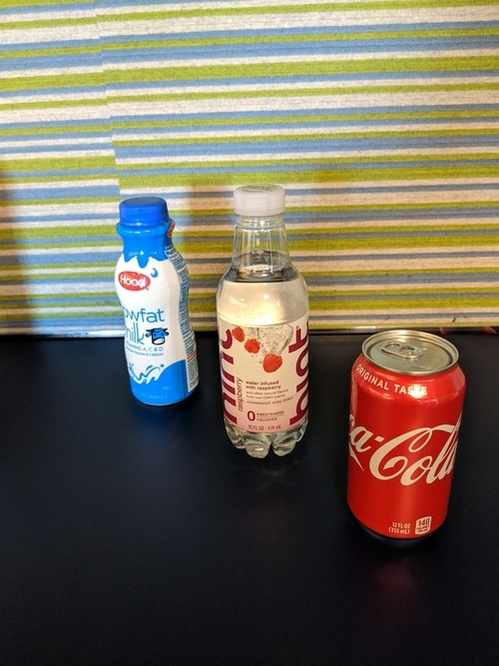

In [9]:
from IPython.display import Image

Image(filename='./odFridgeObjectsMask/images/31.jpg') 

### Convert the downloaded data to JSONL
In this example, the fridge object dataset is annotated in Pascal VOC format, where each image corresponds to an xml file. Each xml file contains information on where its corresponding image file is located and also contains information about the bounding boxes and the object labels. In order to use this data to create an AzureML Datset, we first need to convert it to the required JSONL format.

The following script is creating two .jsonl files (one for training and one for validation) in the parent folder of the dataset. The train / validation ratio corresponds to 20% of the data going into the validation file.

In [10]:
# The jsonl_converter below relies on numpy, pillow, scikit-image and simplification.
# If you haven't have them installed, install them before converting data by runing this cell.
import sys
!{sys.executable} -m pip install numpy==1.18.5 pillow==8.0.1 scikit-image==0.17.2 simplification==0.5.7

In [11]:
from sdkv2_jsonl_converter import convert_mask_in_VOC_to_jsonl

data_path = "./odFridgeObjectsMask/"

# Retrieving default datastore that got automatically created when we setup a workspace
ds = client.datastores.get_default()

###########################################################
## Updated to use default ds instead of ws object
convert_mask_in_VOC_to_jsonl(data_path, ds)
#############################################################

Parsing ./odFridgeObjectsMask/1.xml
Parsing ./odFridgeObjectsMask/10.xml
Parsing ./odFridgeObjectsMask/100.xml
Parsing ./odFridgeObjectsMask/101.xml
Parsing ./odFridgeObjectsMask/102.xml
Parsing ./odFridgeObjectsMask/103.xml
Parsing ./odFridgeObjectsMask/104.xml
Parsing ./odFridgeObjectsMask/105.xml
Parsing ./odFridgeObjectsMask/106.xml
Parsing ./odFridgeObjectsMask/107.xml
Parsing ./odFridgeObjectsMask/108.xml
Parsing ./odFridgeObjectsMask/109.xml
Parsing ./odFridgeObjectsMask/11.xml
Parsing ./odFridgeObjectsMask/110.xml
Parsing ./odFridgeObjectsMask/111.xml
Parsing ./odFridgeObjectsMask/112.xml
Parsing ./odFridgeObjectsMask/113.xml
Parsing ./odFridgeObjectsMask/114.xml
Parsing ./odFridgeObjectsMask/115.xml
Parsing ./odFridgeObjectsMask/116.xml
Parsing ./odFridgeObjectsMask/117.xml
Parsing ./odFridgeObjectsMask/118.xml
Parsing ./odFridgeObjectsMask/119.xml
Parsing ./odFridgeObjectsMask/12.xml
Parsing ./odFridgeObjectsMask/120.xml
Parsing ./odFridgeObjectsMask/121.xml
Parsing ./odFridg

### Upload the JSONL file and images to Datastore  
In order to use the data for training in Azure ML, we upload it to our Azure ML Workspace via a [Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores). The datastore provides a mechanism for you to upload/download data, and interact with it from your remote compute targets. It is an abstraction over Azure Storage.



In [ ]:
#TODO: AzureBlobDatastore object has no attribute 'upload'
# ds.upload(src_dir='./odFridgeObjectsMask', target_path='odFridgeObjectsMask')

Finally, we need to create an Azure ML [Dataset](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores) from the data we uploaded to the Datastore. We create one dataset for training and one for validation.

In [12]:
# Dataset creation (+ from jsonl) not supported yet in v2, and tabular DS is not supported in images v1)
from azure.ml.entities import Data

# TODO: This doesnt' work, ensure dataset is created via the UI

training_dataset_name = "odFridgeObjectsMaskTrainingDataset"
dataset_version = 1

try:
#     training_data = client.data.get(training_dataset_name, dataset_version)
    training_data = Data(name=training_dataset_name, version=dataset_version, local_path=data_path)
    training_data = client.data.create_or_update(training_data)
    print("Uploaded to path  : ", training_data.path)
    print("Datastore location: ", training_data.datastore)
except Exception as e:
    print("Could not create dataset. ", str(e))

training_data

Could not create dataset.  Operation returned an invalid status 'A data version with this name and version already exists. If you are trying to create a new data ver'


Data({'is_anonymous': False, 'name': 'odFridgeObjectsMaskTrainingDataset', 'id': None, 'description': None, 'tags': {}, 'properties': {}, 'base_path': './', 'creation_context': None, 'version': 1, 'datastore': '/subscriptions/e9b2ec51-5c94-4fa8-809a-dc1e695e4896/resourceGroups/sajin_master/providers/Microsoft.MachineLearningServices/workspaces/sajin_enterprise/datastores/workspaceblobstore', 'path': 'LocalUpload/45ff0735ba07159968a24269576e4de2/odFridgeObjectsMask', 'local_path': WindowsPath('C:/Users/sajin/source/repos/Easy-AutoML-MLOps/notebooks/sdk-v2-notebooks/image-notebooks/InstanceSegmentation/odFridgeObjectsMask')})

In [13]:
# Validation dataset
validation_dataset_name = "odFridgeObjectsMaskValidationDataset"
validation_data = client.data.get(validation_dataset_name, dataset_version)

# validation_data = Data(name=validation_dataset_name, version=dataset_version, local_path=data_path)
# validation_data = client.data.create_or_update(validation_data)
    
validation_data


Data({'is_anonymous': False, 'name': 'odFridgeObjectsMaskValidationDataset', 'id': '/subscriptions/e9b2ec51-5c94-4fa8-809a-dc1e695e4896/resourceGroups/sajin_master/providers/Microsoft.MachineLearningServices/workspaces/sajin_enterprise/data/odFridgeObjectsMaskValidationDataset/versions/1', 'description': None, 'tags': {}, 'properties': {'_Image_Column:Image_': '{\n  "column": "image_url",\n  "detailsColumn": "image_details"\n}', '_Label_Column:Label_': '{\n  "column": "label",\n  "type": "InstanceSegmentation"\n}', 'partition_keys': '[]'}, 'base_path': './', 'creation_context': <azure.ml._restclient.v2021_03_01_preview.models._models_py3.SystemData object at 0x0000029D3DB77C48>, 'version': 1, 'datastore': '/subscriptions/e9b2ec51-5c94-4fa8-809a-dc1e695e4896/resourceGroups/sajin_master/providers/Microsoft.MachineLearningServices/workspaces/sajin_enterprise/datastores/workspaceblobstore', 'path': 'odFridgeObjectsMask/validation_annotations.jsonl', 'local_path': None})

In [14]:
print("Training dataset name: " + training_data.name)
print("Validation dataset name: " + validation_data.name)

Training dataset name: odFridgeObjectsMaskTrainingDataset
Validation dataset name: odFridgeObjectsMaskValidationDataset


Validation dataset is optional. If no validation dataset is specified, by default 20% of your training data will be used for validation. You can control the percentage using the `split_ratio` argument - please refer to the documentation for more details. 

This is what the training dataset looks like

In [15]:
training_data.to_pandas_dataframe()

AttributeError: 'Data' object has no attribute 'to_pandas_dataframe'

## Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML runs for image related tasks are specified using the 'AutoMLImageConfig' - please refer to the [documentation](https://github.com/swatig007/automlForImages/blob/main/README.md) for the details on the parameters that can be used and their values. 

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify the specifc model algorithm/hyperparameter config to use or choose to sweep over the hyperparameter space. Currently supported algorithms for Instance segmentation include 'maskrcnn_resnet50_fpn'.

### Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This is for employing a more iterative approach, because with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially and you need more iterations to find optimal configurations.

If you wish to use the default hyperparameter values for a given algorithm (say maskrcnn), you can specify the config for your AutoML Image runs as follows:

In [16]:
from azure.ml._restclient.v2020_09_01_preview.models import (
    GeneralSettings,
    DataSettings,
    TrainingDataSettings,
    ValidationDataSettings,
    LimitSettings
#     TestDataSettings,
#     FeaturizationSettings,
)

from azure.ml.entities._job.automl.training_settings import TrainingSettings
from azure.ml.entities._job.automl.featurization import FeaturizationSettings
# from azure.ml.entities_job.sweep.search_space import SweepDistribution
from azure.ml.entities import AutoMLJob, ComputeConfiguration, Choice


compute_settings = ComputeConfiguration(target=cluster_name)

# general_settings = GeneralSettings(task_type='image-instance-segmentation')
general_settings = GeneralSettings(task_type='classification',
                                   primary_metric= "auc_weighted",
                                  log_verbosity="Info")

training_data_settings = TrainingDataSettings(
    dataset_arm_id='{}:{}'.format(training_data.name, training_data.version)
)
validation_data_settings = ValidationDataSettings(
    dataset_arm_id='{}:{}'.format(validation_data.name, validation_data.version),
)


# TODO: Dont know what this will look like yet in v2 for us
# Target column name should not be required for Images
data_settings = DataSettings(
    training_data=training_data_settings,
    target_column_name="y",
    validation_data=validation_data_settings
)

featurization_settings = FeaturizationSettings(
    featurization_config="off"
)


limit_settings = LimitSettings(
    timeout=60,
    trial_timeout=5,
    max_concurrent_trials=4,
    enable_early_termination=True)

training_settings = TrainingSettings(
    block_list_models=['KNN','LinearSVM'],
    enable_onnx_compatible_models=True,
)

######################
# TODO: create hyperparameter settings so that this will work

search_space = {'model_name': Choice(['maskrcnn_resnet50_fpn'])}

# hyperparameter_settings = HyperparameterSettings(algorithm='Grid',
#                                                  search_space=search_space)

# TODO: create image settings so that this will work
# No img settings in this nb
# image_settings = ImageSettings()

######################

extra_automl_settings = {"save_mlflow": True}

image_maskrcnn_job = AutoMLJob(compute=compute_settings,
                               general_settings=general_settings,
                               data_settings=data_settings,
                               # unecessary settings but trying to make submit work
#                                featurization_settings=featurization_settings,
#                                limit_settings=limit_settings,
#                                training_settings=training_settings,
#                                hyperparameter_settings=hyperparameter_settings,
#                                image_settings=image_settings,
                               properties=extra_automl_settings)

image_maskrcnn_job

AutoMLJob({'name': '1451075c-9cfe-409f-9377-d8d251cb76d8', 'id': None, 'description': None, 'tags': {}, 'properties': {'save_mlflow': True}, 'base_path': './', 'type': 'automl_job', 'creation_context': None, 'experiment_name': 'InstanceSegmentation', 'status': None, 'interaction_endpoints': None, 'log_files': None, 'output': None, 'general_settings': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.GeneralSettings object at 0x0000029D3DB78F48>, 'data_settings': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.DataSettings object at 0x0000029D3DB78F88>, 'limit_settings': None, 'forecasting_settings': None, 'training_settings': None, 'featurization_settings': None, 'compute': {'instance_count': None, 'target': 'gpu-cluster', 'is_local': False, 'instance_type': None, 'location': None, 'properties': None}})

### Submitting an AutoML run for Computer Vision tasks 
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train a vision model using your training dataset.  

In [17]:
created_maskrcnn_job = client.jobs.create_or_update(image_maskrcnn_job)
created_maskrcnn_job

HttpResponseError: Operation returned an invalid status 'Request is invalid and/or missing fields.'

In [18]:
# what is this for?
print("Studio URL: ", created_maskrcnn_job.interaction_endpoints["Studio"].endpoint)

NameError: name 'created_maskrcnn_job' is not defined

In [ ]:
# what is this for?
client.jobs.stream("run id goes here?")

In [ ]:
# TODO: Wait for the remote run to complete (same as automl)
# automl_image_run.wait_for_completion(wait_post_processing=True)

### Hyperparameter sweeping for your AutoML models for computer vision tasks
In this example, we use the AutoMLImageConfig to train an Instance Segmentation model using maskrcnn_resnet50_fpn which is pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label cateogories.

When using AutoML for computer vision, you can perform a hyperparameter sweep over a defined parameter space, to find the optimal model. In this example, we sweep over the hyperparameters for each algorithm, choosing from a range of values for learning_rate, optimizer, etc, to generate a model with the optimal 'accuracy'. If hyperparameter values are not specified, then default values are used for the specified algorithm.  

We use Random Sampling to pick samples from this parameter space and try a total of 20 iterations with these different samples, running 4 iterations at a time on our compute target, which has been previously set up using 4 nodes.  Please note that the more parameters the space has, the more iterations you need to find optimal models. 

We also leverage the Bandit early termination policy that terminates poor performing configs (those that are not within 20% slack of the best perfroming config), thus significantly saving compute resources.

In [ ]:
from azure.ml._restclient.v2020_09_01_preview.models import (
    GeneralSettings,
    DataSettings,
    LimitSettings,
    TrainingDataSettings,
    ValidationDataSettings,
    TestDataSettings,
    FeaturizationSettings,
)

from azure.ml.entities._job.automl.training_settings import TrainingSettings
from azure.ml.entities._job.automl.featurization import FeaturizationSettings
# from azure.ml.entities_job.sweep.search_space import SweepDistribution
from azure.ml.entities import AutoMLJob, ComputeConfiguration, Choice, Uniform

from azure.ml._restclient.v2021_03_01_preview.models import BanditPolicy


compute_settings = ComputeConfiguration(target=cluster_name)

general_settings = GeneralSettings(task_type="image-instance-segmentation",
                                   primary_metric= "mean_average_precision")

limit_settings = LimitSettings(max_total_trials=20,
                               max_concurrent_trials=4)


# TODO: Dont know what this will look like yet in v2 for us
# Target column name should not be required for Images
data_settings = DataSettings(
    training_data=training_data_settings,
    target_column_name="",
    validation_data=validation_data_settings)

######################
# TODO: create HP settings so that this will work

serach_space = { 
    'model_name': Choice(['maskrcnn_resnet50_fpn']),
    'learning_rate': Uniform(min_value=0.0001, max_value=0.001),
    #'warmup_cosine_lr_warmup_epochs': Choice([0, 3]),
    'optimizer': Choice(['sgd', 'adam', 'adamw']),
    'min_size': Choice([600, 800])
}
bandit_policy = BanditPolicy(evaluation_interval=2, slack_factor=0.2, delay_evaluation=6)                       

hyperparameter_settings = HyperparameterSettings(algorithm='Random',
                                                 search_space=search_space,
                                                 early_termination=bandit_policy)
    
# TODO: add image settings (none in this notebook though)
# image_settings = ImageSettings()

######################

# extra_automl_settings = {"save_mlflow": True}

image_job = AutoMLJob(compute=compute_settings,
                      general_settings=general_settings,
                      limit_settings=limit_settings,
                      data_settings=data_settings,
                      hyperparameter_settings=hyperparameter_settings,
#                       image_settings=image_settings,
                      properties=extra_automl_settings)

image_job


In [ ]:
created_image_job = client.jobs.create_or_update(image_job)
created_image_job

In [ ]:
# whats this?
print("Studio URL: ", created_image_job.interaction_endpoints["Studio"].endpoint)

In [ ]:
# what is this for?
client.jobs.stream("run id goes here?")

In [ ]:
# TODO: Wait for the remote run to complete (same as automl)
# automl_image_run.wait_for_completion(wait_post_processing=True)

## Register the optimal vision model from the AutoML run (We need MLFlow for this (?))
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [19]:
# V1 FOR TESTING:
import azureml.core
from azureml.core import Model
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace

print("SDK version:", azureml.core.VERSION)
# experiment_name = "flickr47-logo-detection"
training_run_id ="AutoML_ce2e786e-3705-4c87-a598-15b4702538a3_HD_0"

from azureml.core import Run

ws = Workspace.from_config()

experiment = Experiment(ws, experiment_name)
best_child_run = Run(experiment, training_run_id)

# Get the name of the model
run_properties = best_child_run.get_properties()
model_name = run_properties["model_name"]

SDK version: 1.32.0


In [20]:
# print(run_properties['model_data_location'])
# print(run_properties)

# print(ds.id)

# azureml_model = best_child_run.register_model(model_name=model_name, model_path='outputs')

aml://artifact/ExperimentRun/dcid.AutoML_ce2e786e-3705-4c87-a598-15b4702538a3_HD_0/outputs/model.pt
{'_azureml.ComputeTargetType': 'amlcompute', 'ContentSnapshotId': 'fea9ba51-480b-4063-bad8-ce2902cb50dc', 'ProcessInfoFile': 'azureml-logs/process_info.json', 'ProcessStatusFile': 'azureml-logs/process_status.json', 'azureml.RuntimeType': 'Hosttools', 'score': '0.628498911857605', 'model_name': 'AutoMLce2e786e30', 'runTemplate': 'automl_child', 'run_algorithm': 'maskrcnn_resnet50_fpn', 'model_output_path': 'outputs/model.pt', 'scoring_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_ce2e786e-3705-4c87-a598-15b4702538a3_HD_0/outputs/scoring_file_v_1_0_0.py', 'conda_env_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_ce2e786e-3705-4c87-a598-15b4702538a3_HD_0/outputs/conda_env_v_1_0_0.yml', 'model_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_ce2e786e-3705-4c87-a598-15b4702538a3_HD_0/outputs/model.pt'}
/subscriptions/e9b2ec51-5c94-4fa8-809a-dc1e695e4896/resour

In [ ]:
# From v1: Register the model from the best run
# best_child_run = automl_image_run.get_best_child()
# model_name = best_child_run.properties['model_name']
# model = best_child_run.register_model(model_name = model_name, model_path='outputs/model.pt')

In [21]:
# From AutoML notebook : Can't access properties right now - https://msdata.visualstudio.com/Vienna/_workitems/edit/1252056
# Will probably need MlFlow support to do this, which is NOT yet implemented for Images
model_name = "AutoMLce2e786e30" # best_run.properties['model_name']
output_path= "outputs"

In [23]:
#### Uses ML Flow to get parent/child run###########################################################
# Mlflow does not work with images
from mlflow.tracking import MlflowClient

job_name = "AutoML_ce2e786e-3705-4c87-a598-15b4702538a3_HD_0"
# job_name = created_job.name

mlflow_client = MlflowClient()

# TODO: gives: MlflowException: Run '<RunId>' not found (got same error in bank notebook)
mlflow_parent_run = mlflow_client.get_run(job_name)

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

best_child_run = mlflow_client.get_run(best_child_run_id)
best_child_run
#######################################################################################################

MlflowException: Run 'AutoML_ce2e786e-3705-4c87-a598-15b4702538a3' not found

In [35]:
from azure.ml.entities._assets import Model

# Note: This is not using MLFlow's deployment mechanism at all (flavors, scoring script / examples etc.)
# Create / register the model
# TODO: This doesn't track the lineage (run id) from which the model is created. 

model_data_location = best_child_run.properties['model_data_location']
# How can we use it with a remote path?
azure_model = Model(name=model_name, version=1, local_path=os.path.join(output_path, "model.pt"))

# Operation returned an invalid status
#No blobs found in storage at model asset path: aml://artifact/ExperimentRun/dcid.AutoML_ce2e786e-370'

# azure_model = Model(name=model_name, version=9, datastore=ds.id, path=model_data_location)
azure_model = client.models.create_or_update(azure_model)
azure_model

Model({'is_anonymous': False, 'name': 'AutoMLce2e786e30', 'id': '/subscriptions/e9b2ec51-5c94-4fa8-809a-dc1e695e4896/resourceGroups/sajin_master/providers/Microsoft.MachineLearningServices/workspaces/sajin_enterprise/models/AutoMLce2e786e30/versions/1', 'description': None, 'tags': {}, 'properties': {'azureml.modelFormat': 'CUSTOM'}, 'base_path': './', 'creation_context': <azure.ml._restclient.v2021_03_01_preview.models._models_py3.SystemData object at 0x0000029D3DA6E348>, 'version': 1, 'datastore': '/subscriptions/e9b2ec51-5c94-4fa8-809a-dc1e695e4896/resourceGroups/sajin_master/providers/Microsoft.MachineLearningServices/workspaces/sajin_enterprise/datastores/workspaceblobstore', 'path': 'LocalUpload/281ee1cc60e848adb8eb5167b4aad0ca/model.pt', 'local_path': None, 'utc_time_created': None, 'flavors': {}})

In [36]:
# # Register via. MLFlow (Not recommended)
# AttributeError: 'Run' object has no attribute 'info'

child_run_id = job_name
mlflow_model = mlflow.register_model(
    "runs:/{}/outputs".format(child_run_id),
    "mlflow_automl_model"
)

mlflow_model

MlflowException: Model Registry features are not supported by the store with URI: 'file:///C:/Users/sajin/source/repos/Easy-AutoML-MLOps/notebooks/sdk-v2-notebooks/image-notebooks/InstanceSegmentation/mlruns'. Stores with the following URI schemes are supported: ['databricks', 'http', 'https', 'postgresql', 'mysql', 'sqlite', 'mssql', 'azureml'].

In [45]:
# TODO: This is from v1 since mlflow isnt working yet
azureml_model = best_child_run.register_model(model_name=model_name, model_path='outputs')

## Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)). ACI is the perfect option for testing deployments, while AKS is better suited for for high-scale, production usage.  
In this tutorial, we will deploy the model as a web service in AKS.

You can then deploy the model as an AKS web service.

In [48]:
from azure.ml.entities import Endpoint, ManagedOnlineEndpoint, Environment, \
CodeConfiguration, ManagedOnlineDeployment, ManualScaleSettings, Code

# conda_environment_yaml = best_child_run.properties['conda_env_data_location']
# inference_script_file_name = best_child_run.properties['scoring_data_location']

inference_script_file_name = os.path.join(output_path, "scoring_file_v_1_0_0.py")
conda_environment_yaml = os.path.join(output_path, "conda_env_v_1_0_0.yml")

print("Inference File: ", inference_script_file_name)

# Figure out if can just use training run env
# Ex: environment = best_child_run.get_environment()
print("Conda Environment File: ", conda_environment_yaml)

assert os.path.exists(inference_script_file_name)
assert os.path.exists(conda_environment_yaml)

# id_suffix = best_child_run.info.run_id[:6]
id_suffix = job_name[-6:]
print(id_suffix)

# Prepare the deployment configuration
environment = Environment(
    name="environment-{}".format(id_suffix),
    version=1,
    path=".",
    conda_file=conda_environment_yaml,
    docker_image="mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20210301.v1",# whats this
)

code = Code(
    name="environment-{}".format(id_suffix),
    version=1,
    local_path=inference_script_file_name,
)
code_configuration = CodeConfiguration(
    code=code,
    scoring_script=inference_script_file_name
)

scale_settings = ManualScaleSettings(
    scale_type="Manual",
    min_instances=1,
    max_instances=2,
    instance_count=1
)

# Valid values are: [Standard_D16s_v3, Standard_D2s_v3, Standard_D32s_v3, Standard_D4s_v3, Standard_D64s_v3,
# Standard_D8s_v3, Standard_DS2_v2, Standard_DS3_v2, Standard_DS4_v2, Standard_DS5_v2, Standard_F16s_v2,
# Standard_F2s_v2, Standard_F32s_v2, Standard_F48s_v2, Standard_F4s_v2, Standard_F64s_v2, Standard_F72s_v2,
# Standard_F8s_v2, Standard_NC12s_v2, Standard_NC12s_v3, Standard_NC16as_T4_v3, Standard_NC24s_v2, Standard_NC24s_v3, 
# Standard_NC4as_T4_v3, Standard_NC64as_T4_v3, Standard_NC6s_v2, Standard_NC6s_v3, Standard_NC8as_T4_v3, Standard_ND24s,
# Standard_ND40rs_v2, Standard_ND96asr_v4]

deployment = ManagedOnlineDeployment(
    name="deployment-{}".format(id_suffix),
    model=azure_model,
    environment=environment,
    code_configuration=code_configuration,
#     instance_type="Standard_F2s_v2",
    instance_type="Standard_NC6s_v2",
    scale_settings=scale_settings,
                                    )
online_endpoint = ManagedOnlineEndpoint(
    name="endpoint-{}".format(id_suffix),
    deployments=[deployment],
    description="Demo Image model deployment",
    tags={"deployed_using": "sdkv2"}
)
##### Loading from YAML
# endpoint = Endpoint.load("/home/schrodinger/automl/Easy-AutoML-MLOps/notebooks/3-automl-remote-compute-run/endpoint.yml")

try:
    client.endpoints.create(online_endpoint)
except Exception as e:
    import traceback
    print("Deployment failed: ", str(e))
    traceback.print_exc()
    
#################TODO###################################
# Fails with quota issue, but on portal shows as succeded
# https://ml.azure.com/endpoints/realtime/endpoint-2538a3/detail?wsid=/subscriptions/e9b2ec51-5c94-4fa8-809a-dc1e695e4896/resourcegroups/sajin_master/workspaces/sajin_enterprise&tid=72f988bf-86f1-41af-91ab-2d7cd011db47

Inference File:  outputs\scoring_file_v_1_0_0.py
Conda Environment File:  outputs\conda_env_v_1_0_0.yml
2538a3


The deployment request sajin_enterprise-endpoint-2538a3-4303478 was accepted. ARM deployment URI for reference: 
https://ms.portal.azure.com/#blade/HubsExtension/DeploymentDetailsBlade/overview/id/%2Fsubscriptions%2Fe9b2ec51-5c94-4fa8-809a-dc1e695e4896%2FresourceGroups%2Fsajin_master%2Fproviders%2FMicrosoft.Resources%2Fdeployments%2Fsajin_enterprise-endpoint-2538a3-4303478
Registering model version (AutoMLce2e786e30:1)  Done (2s)
Registering environment version (environment-2538a3:1)  Done (5s)
Creating endpoint endpoint-2538a3 ..  Done (28s)


Deployment failed:  (DeploymentFailed) At least one resource deployment operation failed. Please list deployment operations for details. Please see https://aka.ms/DeployOperations for usage details.
Code: DeploymentFailed
Message: At least one resource deployment operation failed. Please list deployment operations for details. Please see https://aka.ms/DeployOperations for usage details.
Exception Details:	(BadRequest) {
	  "error": {
	    "code": "BadRequest",
	    "message": "The request is invalid.",
	    "details": [
	      {
	        "code": "InferencingClientCreateDeploymentFailed",
	        "message": "InferencingClient HttpRequest error, error detail: {\"errors\":{\"VmSize\":[\"Not enough quota available for Standard_NC6s_v2 in SubscriptionId e9b2ec51-5c94-4fa8-809a-dc1e695e4896. Current usage/limit: 0/0. Additional requested: 12\"]},\"type\":\"https://tools.ietf.org/html/rfc7231#section-6.5.1\",\"title\":\"One or more validation errors occurred.\",\"status\":400,\"traceId\":\"

Traceback (most recent call last):
  File "C:\Users\sajin\Anaconda3\envs\dpv2\lib\site-packages\azure\core\polling\base_polling.py", line 482, in run
    self._poll()
  File "C:\Users\sajin\Anaconda3\envs\dpv2\lib\site-packages\azure\core\polling\base_polling.py", line 521, in _poll
    raise OperationFailed("Operation failed or canceled")
azure.core.polling.base_polling.OperationFailed: Operation failed or canceled

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\sajin\AppData\Local\Temp/ipykernel_25644/396467781.py", line 75, in <module>
    client.endpoints.create(online_endpoint)
  File "C:\Users\sajin\Anaconda3\envs\dpv2\lib\site-packages\azure\ml\_operations\endpoint_operations.py", line 218, in create
    return self._create_online_endpoint(internal_endpoint=endpoint, no_wait=no_wait)
  File "C:\Users\sajin\Anaconda3\envs\dpv2\lib\site-packages\azure\ml\_operations\endpoint_operations.py", line 597, in _cre

In [49]:
# Get logs from deployed web service
# Returns nothing at the moment (?)
client.endpoints.get_deployment_logs(online_endpoint.name, deployment.name, lines=200)

## Test the web service
Finally, let's test our deployed web service to predict new images. You can pass in any image. In this case, we'll use a random image from the dataset and pass it to te scoring URI.

In [54]:
online_endpoint

ManagedOnlineEndpoint({'name': 'endpoint-2538a3', 'id': None, 'description': 'Demo Image model deployment', 'tags': {'deployed_using': 'sdkv2'}, 'properties': {}, 'base_path': './', 'type': 'online', 'auth_mode': 'aml_token', 'location': None, 'traffic': {}, 'scoring_uri': None, 'swagger_uri': None, 'deployments': [<azure.ml.entities._endpoint.online_deployment.ManagedOnlineDeployment object at 0x0000029D3DB740C8>], 'identity': None, 'provisioning_state': None})

In [53]:
# URL for the web service - No scoring_uri even though endpoint succeeded?
scoring_uri = online_endpoint.scoring_uri
scoring_uri

In [52]:
import requests

# URL for the web service
scoring_uri = online_endpoint.scoring_uri

# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()

sample_image = './test_image.jpg'

# Load image data
data = open(sample_image, 'rb').read()

# Set the content type
headers = {'Content-Type': 'application/octet-stream'}

# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'

# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print(resp.text)

MissingSchema: Invalid URL 'None': No schema supplied. Perhaps you meant http://None?

## Visualize predictions
Now that we have scored a test image, we can visualize the predictions for this image

In [55]:
%pip install --upgrade matplotlib

Note: you may need to restart the kernel to use updated packages.


NameError: name 'resp' is not defined

<Figure size 1296x864 with 0 Axes>

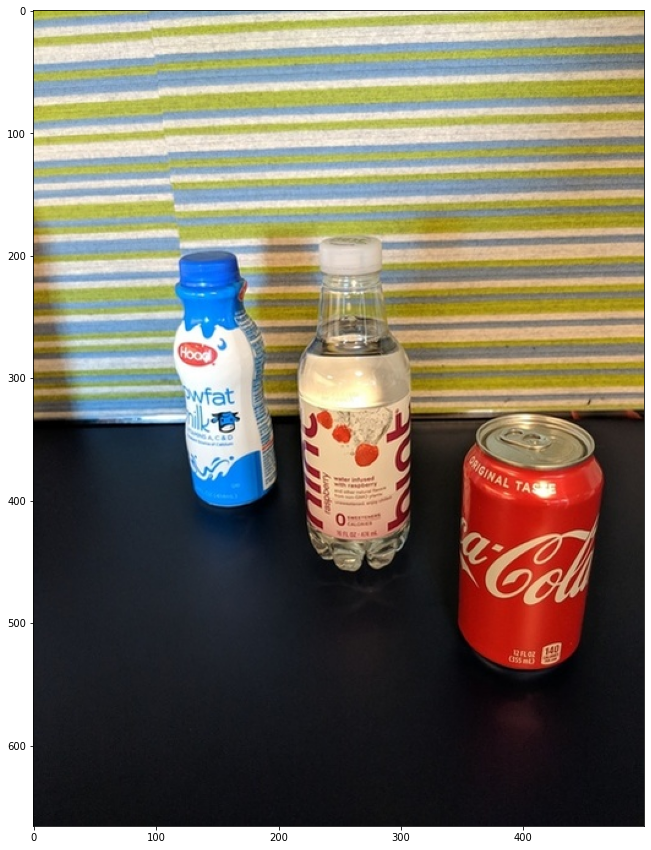

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15))
# Display the image
ax.imshow(img_np)

# draw box and label for each detection 
detections = json.loads(resp.text)
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    polygon = detect['polygon']
    conf_score = detect['score']
    if conf_score > 0.6:
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print('{}: [{}, {}, {}, {}], {}'.format(detect['label'], round(topleft_x, 3), 
                                                round(topleft_y, 3), round(width, 3), 
                                                round(height, 3), round(conf_score, 3)))

        color = np.random.rand(3) #'red'
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=2, edgecolor=color,facecolor='none')

        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, label, color=color, fontsize=20)
        
        polygon_np = np.array(polygon[0])
        polygon_np = polygon_np.reshape(-1, 2)
        polygon_np[:, 0] *= x
        polygon_np[:, 1] *= y
        poly = patches.Polygon(polygon_np, True, facecolor=color, alpha=0.4)
        ax.add_patch(poly)
        poly_line = Line2D(polygon_np[:, 0], polygon_np[:, 1], linewidth=2,
                           marker='o', markersize=8, markerfacecolor=color)
        ax.add_line(poly_line)

plt.show()